In [1]:
#https://github.com/wegeneredv-de/CaptchaSolver
!pip install imutils
#https://stackoverflow.com/a/44064546
#!pip uninstall opencv-python 
#!conda install -y python=3.6
#!conda install -y -c menpo opencv3
#!pip install numpy

  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/25/b6/87/cfa15b3f5fe59af02e5dc7be746c4ae68adc4782462ed374d5
Successfully built imutils


In [2]:
#extract_single_letters_from_captchas.py
import os
import os.path
import cv2
import glob
import imutils
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"
OUTPUT_FOLDER = "extracted_letter_images"
# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}
# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
   # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]
    letter_image_regions = []
    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))
    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue
    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box
        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)
        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)
        # increment the count for the current key
        counts[letter_text] = count + 1

[INFO] processing image 1/583
[INFO] processing image 2/583
[INFO] processing image 3/583
[INFO] processing image 4/583
[INFO] processing image 5/583
[INFO] processing image 6/583
[INFO] processing image 7/583
[INFO] processing image 8/583
[INFO] processing image 9/583
[INFO] processing image 10/583
[INFO] processing image 11/583
[INFO] processing image 12/583
[INFO] processing image 13/583
[INFO] processing image 14/583
[INFO] processing image 15/583
[INFO] processing image 16/583
[INFO] processing image 17/583
[INFO] processing image 18/583
[INFO] processing image 19/583
[INFO] processing image 20/583
[INFO] processing image 21/583
[INFO] processing image 22/583
[INFO] processing image 23/583
[INFO] processing image 24/583
[INFO] processing image 25/583
[INFO] processing image 26/583
[INFO] processing image 27/583
[INFO] processing image 28/583
[INFO] processing image 29/583
[INFO] processing image 30/583
[INFO] processing image 31/583
[INFO] processing image 32/583
[INFO] processing

[INFO] processing image 261/583
[INFO] processing image 262/583
[INFO] processing image 263/583
[INFO] processing image 264/583
[INFO] processing image 265/583
[INFO] processing image 266/583
[INFO] processing image 267/583
[INFO] processing image 268/583
[INFO] processing image 269/583
[INFO] processing image 270/583
[INFO] processing image 271/583
[INFO] processing image 272/583
[INFO] processing image 273/583
[INFO] processing image 274/583
[INFO] processing image 275/583
[INFO] processing image 276/583
[INFO] processing image 277/583
[INFO] processing image 278/583
[INFO] processing image 279/583
[INFO] processing image 280/583
[INFO] processing image 281/583
[INFO] processing image 282/583
[INFO] processing image 283/583
[INFO] processing image 284/583
[INFO] processing image 285/583
[INFO] processing image 286/583
[INFO] processing image 287/583
[INFO] processing image 288/583
[INFO] processing image 289/583
[INFO] processing image 290/583
[INFO] processing image 291/583
[INFO] p

[INFO] processing image 518/583
[INFO] processing image 519/583
[INFO] processing image 520/583
[INFO] processing image 521/583
[INFO] processing image 522/583
[INFO] processing image 523/583
[INFO] processing image 524/583
[INFO] processing image 525/583
[INFO] processing image 526/583
[INFO] processing image 527/583
[INFO] processing image 528/583
[INFO] processing image 529/583
[INFO] processing image 530/583
[INFO] processing image 531/583
[INFO] processing image 532/583
[INFO] processing image 533/583
[INFO] processing image 534/583
[INFO] processing image 535/583
[INFO] processing image 536/583
[INFO] processing image 537/583
[INFO] processing image 538/583
[INFO] processing image 539/583
[INFO] processing image 540/583
[INFO] processing image 541/583
[INFO] processing image 542/583
[INFO] processing image 543/583
[INFO] processing image 544/583
[INFO] processing image 545/583
[INFO] processing image 546/583
[INFO] processing image 547/583
[INFO] processing image 548/583
[INFO] p

In [3]:
#train_model.py
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
# initialize the data and labels
data = []
labels = []
# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)
    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)
    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)
# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)
# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)
# Build the neural network!
model = Sequential()
# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))
# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)
# Save the trained model to disk
model.save(MODEL_FILENAME)
model.summary()

Using TensorFlow backend.


Train on 3351 samples, validate on 1117 samples
Epoch 1/10
3351/3351 [==============================] - 2s - loss: 1.5696 - acc: 0.6010 - val_loss: 0.1769 - val_acc: 0.9669
Epoch 2/10
3351/3351 [==============================] - 1s - loss: 0.0986 - acc: 0.9815 - val_loss: 0.0407 - val_acc: 0.9937
Epoch 3/10
3351/3351 [==============================] - 1s - loss: 0.0348 - acc: 0.9943 - val_loss: 0.0363 - val_acc: 0.9919
Epoch 4/10
3351/3351 [==============================] - 1s - loss: 0.0140 - acc: 0.9964 - val_loss: 0.0266 - val_acc: 0.9955
Epoch 5/10
3351/3351 [==============================] - 1s - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0231 - val_acc: 0.9964
Epoch 6/10
3351/3351 [==============================] - 1s - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0145 - val_acc: 0.9964
Epoch 7/10
3351/3351 [==============================] - 2s - loss: 5.6773e-04 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9964
Epoch 8/10
3351/3351 [==============================] - 1s - loss: 3.2159

CAPTCHA text is: 6SGA


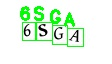

CAPTCHA text is: 2M5Y


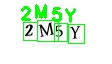

CAPTCHA text is: 2LTL


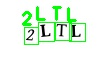

CAPTCHA text is: 8BFG


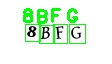

CAPTCHA text is: G5Z7


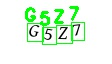

CAPTCHA text is: G3ES


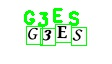

CAPTCHA text is: 8DRV


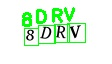

CAPTCHA text is: K2S6


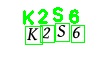

CAPTCHA text is: 2VBU


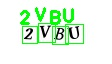

CAPTCHA text is: 4P4S


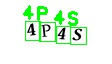

In [10]:
#solve_captchas_with_model.py
from keras.models import load_model
from helpers import resize_to_fit
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle


MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    #cv2.imshow("Output", output) #ERROR error: /tmp/build/80754af9/opencv_1512491966934/work/modules/highgui/src/window.cpp:611: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage
    #WORKAROUND https://stackoverflow.com/a/11855133/8800831
    cv2.imwrite('workaround.jpg',output)
    from IPython.display import Image
    display(Image(filename='workaround.jpg'))    